In [6]:
import obspy
import numpy
import math
import cmath
from obspy import UTCDateTime, read, Trace, Stream
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib
%matplotlib inline
import scipy

from scipy import signal
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
import obspy

In [16]:
from obspy import read


#st = read("FAr_NL_2019-10-12T18:21:15Z_HNX.mseed")
#st = read("FAr_NL_2019-10-12T18:21:15Z_HNY.mseed")
#st = read("FAr_NL_2019-10-12T18:21:15Z_HNZ.mseed")

#st = read("FAr_FL660_2019-10-12T18:21:15Z_HNX.mseed") # TOP FUEL6
#st = read("FAr_FL660_2019-10-12T18:21:15Z_HNY.mseed")
#st = read("FAr_FL660_2019-10-12T18:21:15Z_HNZ.mseed")

#st = read("FAr_FL1K_2019-10-12T18:21:15Z_HNX.mseed")
#st = read("FAr_FL1K_2019-10-12T18:21:15Z_HNY.mseed")
#st = read("FAr_FL1K_2019-10-12T18:21:15Z_HNZ.mseed")
#st.spectrogram()
#x1=6600
#x2=7000


#plt.savefig('./fallClean/Figures/spectra_x.png', bbox_inches='tight')
#print(st[0].data)

#st = read("./FallClean/Corrected/FAr_FL660_2019-10-12T21:44:29Z_HNX.mseed") # FC # Funny Car Q4 Heat 6'
#st = read("./FallClean/Corrected/FAr_FL660_2019-10-12T21:44:29Z_HNY.mseed")
st = read("./FallClean/Corrected/FAr_FL660_2019-10-12T21:44:29Z_HNZ.mseed")
print(st)

st[0].stats

1 Trace(s) in Stream:
XX.FL660.00.HNZ | 2019-10-12T21:44:19.001200Z - 2019-10-12T21:45:19.001200Z | 200.0 Hz, 12001 samples


         network: XX
         station: FL660
        location: 00
         channel: HNZ
       starttime: 2019-10-12T21:44:19.001200Z
         endtime: 2019-10-12T21:45:19.001200Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 12001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 211, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 108032})

In [17]:

# create a new empty trace
stg = Stream([Trace()])

# conversion factor
gravity = 4096

# make stream a list to apply conversion factor
stList = st[0].data.tolist()
gData = []

for value in stList:
    gData.append(value/gravity)

first = gData[0]
last = gData[-1]
coef = numpy.polyfit(range(len(gData)),gData,1)
print(coef)
slope = coef[0]

# Copy the data into a new detrended data file
detrend = gData.copy()

# remove slope
for i in range(len(detrend)):
    detrend[i] = detrend[i] - i*slope

mean = numpy.mean(detrend)
for i in range(len(detrend)):
    detrend[i] = detrend[i] - mean
    
# Taper

N = len(detrend)
taper = numpy.ones(N)
taperData = numpy.zeros(N)
for idx in range(N):
    # hanning
    taper[idx] = 0.5 - 0.5*math.cos(2*math.pi*idx/N)
    taperData[idx] = detrend[idx] * taper[idx]

gData = detrend

# obspy likes numpy arrays
numpyList= np.asarray(gData, dtype=np.float32) 

# new obspy stream with amp values in g
stg[0].data = numpyList


# update the stats
stg[0].stats['starttime'] = '2019-10-12T21:44:19.001200Z'
stg[0].stats['delta'] = '0.005'
stg[0].stats['sampling_rate'] = '200.0'
stg[0].stats['network'] = 'XX'
stg[0].stats['station'] = 'FL660'
stg[0].stats['channel'] = 'HNXYZ'
stg[0].stats['location'] = 'zMAX'
print(stg[0].stats)

[  4.88046256e-09  -7.72600303e-03]
         network: XX
         station: FL660
        location: zMAX
         channel: HNXYZ
       starttime: 2019-10-12T21:44:19.001200Z
         endtime: 2019-10-12T21:45:19.001200Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 12001
           calib: 1.0


In [18]:
from datetime import datetime, timedelta
import pandas as pd

# Plot using matplot lib
from scipy import signal
#create figure
fig = plt.figure(figsize=(50, 10))
 #

# TIMES IN X Y AND Z ARE ALL THE SAME
        
startSTZ = stg[0].stats['starttime']
deltaSTZ = stg[0].stats['delta']
nptSTZ = stg[0].stats['npts']

# MAKE TIME STRING INTO DATETIME FORMAT

startSTZ = str(startSTZ)
endSTZ = str(stg[0].stats['endtime'])
startSTZ = datetime.strptime(startSTZ, '%Y-%m-%dT%H:%M:%S.%fZ')
endSTZ = datetime.strptime(endSTZ, '%Y-%m-%dT%H:%M:%S.%fZ')
idxStart = 0
idxEnd = nptSTZ
timeStart = deltaSTZ * idxStart # START TIME IS FIRST INDEX
#print('timeStart',timeStart)
timeEnd = deltaSTZ * idxEnd # ENDTIME IS LAST INDEX
#print('timeEnd',timeEnd)
#print('timedelta',timedelta(seconds=timeStart))

st = pd.Timestamp(startSTZ+timedelta(seconds=timeStart)) # This was more complicated than it needs to be
fin = pd.Timestamp(startSTZ+timedelta(seconds=timeEnd))
#print("st",st)
#print('fin',fin)

# Make a time domain of time * delta with delta pnts between

timeDomain = np.linspace(st.value,fin.value,nptSTZ)
timeDomain = pd.to_datetime(timeDomain)
print(len(timeDomain))


12001


<Figure size 3600x720 with 0 Axes>

In [19]:
def plotData(data,data2,x1,x2):

    # plot and label graph
    fig = plt.figure(figsize=(30, 15))
    plt.plot(timeDomain[x1:x2],data[x1:x2], linewidth=1.0, label = 'Original')
    plt.plot(timeDomain[x1:x2],data2[x1:x2], linewidth=2.0, label = '75 - 90 Hz Filter')
    plt.title('FL660 - Funny Car Q4 Heat 6 Fall 2019 - y', fontsize = 30)
    plt.xlabel('Time', fontsize = 30)
    plt.ylabel('Ground Acceleration (g)', fontsize = 30)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 30)
    plt.legend(loc = 'upper right', fontsize = '25')
    plt.grid()
    plt.show()
    
def plotData1(data,x1,x2):

    # plot and label graph
    fig = plt.figure(figsize=(30, 15))
    plt.plot(timeDomain[x1:x2],data[x1:x2], linewidth=1.0)
    plt.title('FL660 - Funny Car Q4 Heat 6 Fall 2019 - z', fontsize = 30)
    plt.xlabel('Time', fontsize = 30)
    plt.ylabel('Ground Acceleration (g)', fontsize = 30)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 30)
    plt.grid()
    plt.show()
      
def plotDFT(dft):
    #N = 200
    sampRate = 200.0
    #freqVals = numpy.linspace(0, sampRate/2, N//2+1)
    freqVals = numpy.linspace(0, sampRate/2, len(dft))
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(freqVals, abs(dft)) #PLOT AGAINST FREQ
    plt.title('DFT y FL660')
    plt.xlabel('frequency')
    plt.ylabel('amplitude')
    plt.show()

In [89]:
samprate = stg[0].stats.sampling_rate
nyquist=0.5*samprate

#lowcut = 0.1 #Hz
#highcut = 20 # Hz

#lowcut = 10 #Hz
#highcut = 20 # Hz

##lowcut = 45  # Hz
#highcut = 65  # Hz

#lowcut = 65 # Hz
#highcut = 76 # Hz

lowcut = 75 # Hz
highcut = 99 # Hz

#lowcut = 66 # Hz
#highcut = 70 # Hz

low = lowcut / nyquist
high = highcut / nyquist
order = 4

# Single pass filter causes a non-linear phase shift
butter_sos = signal.butter(order, [low, high], analog=False, btype='band', output='sos')
filteredData = signal.sosfilt(butter_sos, data)

# Filter with double pass to correct for non-linear phase shift
butter2Pass_sos = signal.butter(order//2, [low, high], analog=False, btype='band', output='sos')

filtFiltData = signal.sosfiltfilt(butter2Pass_sos, data)
print(len(filtFiltData))

12001


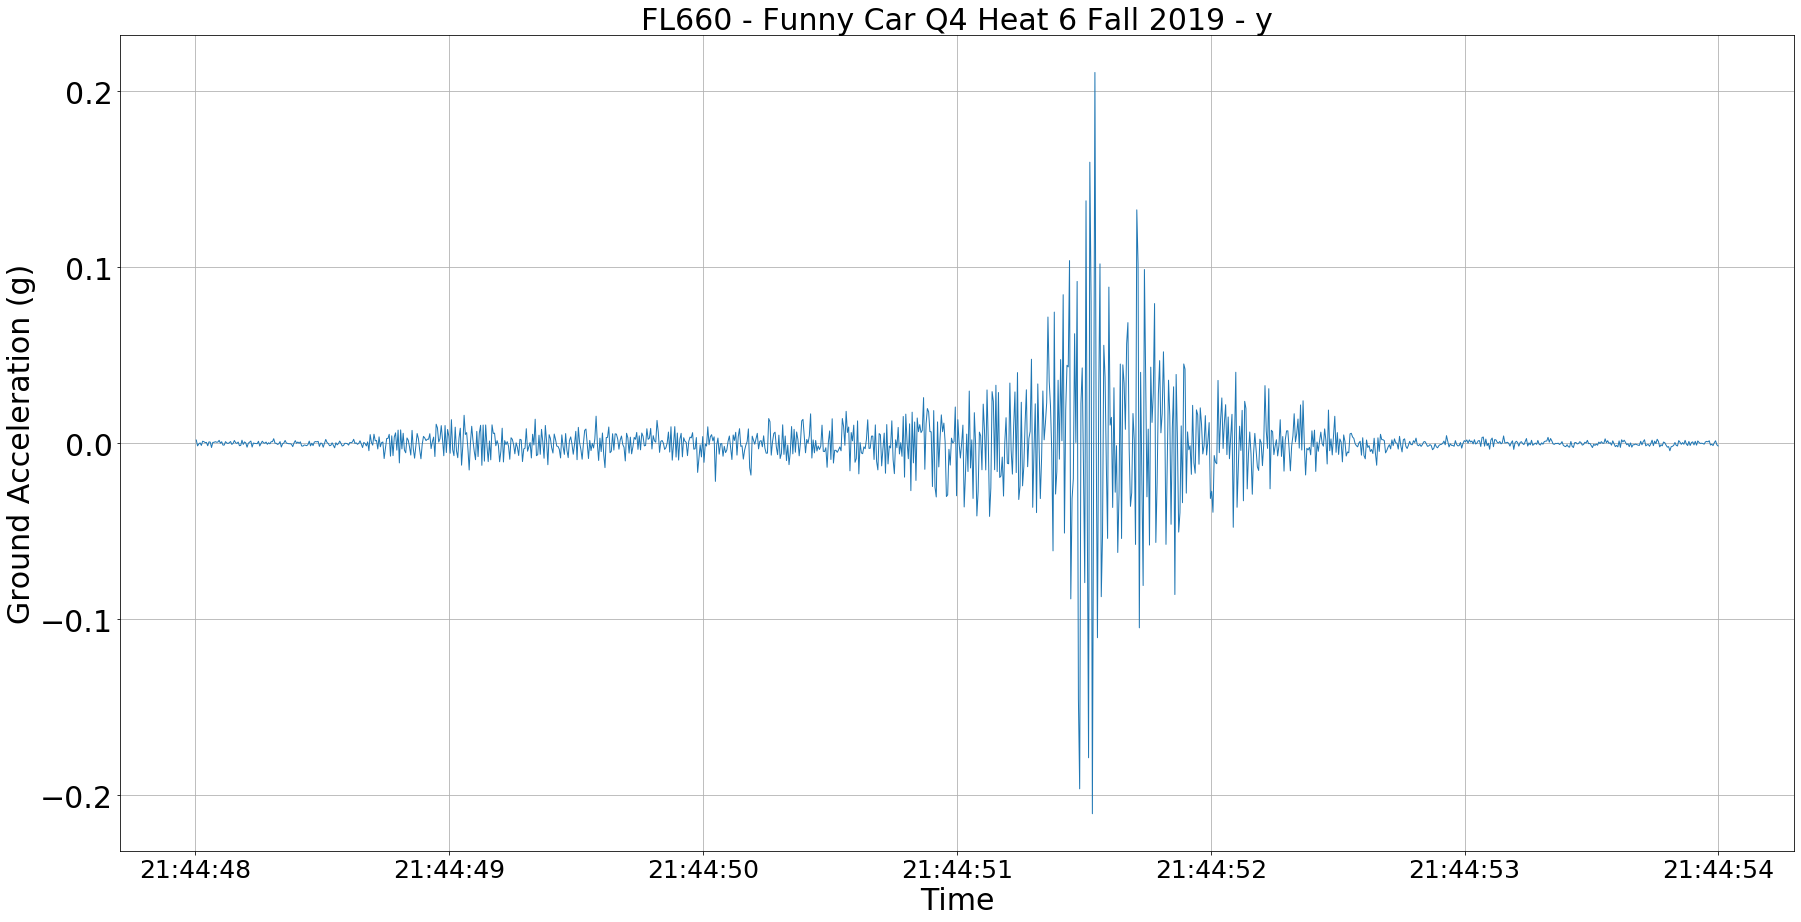

In [20]:
data = stg[0].data
x1=5800
x2=7000
#dft = scipy.fft.rfft(filtFiltData)
#plotDFT(dft)
#plotData(data,filteredData,x1,x2)
#print('x')

#plotData(data,filtFiltData,x1,x2)
plotData1(data,x1,x2)

In [ ]:


#x1=6200
#x2=6300

#plotData(data,filtFiltData,x1,x2)


#dft = scipy.fft.rfft(data[x1:x2])
#sampRate = 200.0
#N = x2-x1
#freqVals = numpy.linspace(0, sampRate/2, N//2+1)
#plt.plot(freqVals,dft)

In [41]:
print(6240-6600)
print(6300-5940)

-360
360
